All data are stored as 

{root} / {episode} / {'rgb', 'depth'} / {index}.{'png', 'jpg'}

## TUM
Download, decompress and rename timestamp name

Link: https://cvg.cit.tum.de/data/datasets/rgbd-dataset/download

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import os
PREFIX = "https://vision.in.tum.de/"
res = requests.get("https://vision.in.tum.de/data/datasets/rgbd-dataset/download")
soup = BeautifulSoup(res.text)
linktags = soup.find_all('a', href=re.compile("/rgbd/dataset.*?tgz"))
linktags = linktags[:(len(linktags)//2)]
links = []
for a in linktags:
    relative = a.get("href")
    if "checkerboard_large" not in relative and "calibration" not in relative:
        links.append(PREFIX+relative)
FOLDER = "/home/zqy/hzt/UniSpeaker/data/rgbd_data/tumrgbd/"
for link in links:
    cmd = "wget -P %s %s"%(FOLDER, link)
    os.system(cmd)      

In [ ]:
FOLDER = "/home/zqy/hzt/UniSpeaker/data/rgbd_data/tumrgbd/"
for link in links:
    cmd = "wget -P %s -q %s"%(FOLDER, link)
    os.system(cmd)

In [ ]:
os.system(f"ls {FOLDER} | xargs -n1 tar -zxvf")

In [ ]:
import shutil
from tqdm.notebook import tqdm
import os
FOLDER = "/home/zqy/hzt/UniSpeaker/data/rgbd_data/tumrgbd/"
NEW_FOLDER = "/home/zqy/hzt/UniSpeaker/data/rgbd_data/tumrgbd_clean/"
os.system(f"rm -r {NEW_FOLDER}")
os.makedirs(NEW_FOLDER, exist_ok=True)
def int_index(a):
    return round(float(a.replace(".png",""))*1000,1)
def seq_align(a, b):
    if len(a)==len(b):
        return a,b
    new_b = []
    for v in a:
        min_dist = 0x7f7f7f7f
        min_k = b[0]
        for k in b:
            if abs(int_index(v)-int_index(k))<min_dist:
                min_dist = abs(int_index(v)-int_index(k))
                min_k = k
        new_b.append(min_k)
    assert len(a)==len(new_b)
    return a, new_b

for episode in tqdm(os.listdir(FOLDER)):
    ep_folder = os.path.join(FOLDER, episode)
    rgbs_ = sorted(os.listdir(os.path.join(ep_folder, "rgb")))
    depths_ = sorted(os.listdir(os.path.join(ep_folder, "depth")))

    rgbs, depths = seq_align(rgbs_, depths_)

    rgb_min = float(rgbs[0].replace(".png",""))
    depth_min = float(depths[0].replace(".png",""))

    rgbs_new = [str(round((float(v.replace(".png",""))-rgb_min)*1000))+".png" for v in rgbs]
    # depths_new = [str(round((float(v.replace(".png",""))-depth_min)*1000))+".png" for v in depths]
    depths_new = rgbs_new # approximately copying rgb timestamp to depth timestamp
    assert len(set(rgbs_new))==len(set(depths_new))

    os.makedirs(os.path.join(NEW_FOLDER, episode, "rgb"), exist_ok=True)
    os.makedirs(os.path.join(NEW_FOLDER, episode, "depth"), exist_ok=True)
    for r1,r2 in zip(rgbs, rgbs_new):
        f1 = os.path.join(FOLDER, episode, "rgb", r1)
        f2 = os.path.join(NEW_FOLDER, episode, "rgb", r2)
        shutil.copy2(f1,f2)
    for r1,r2 in zip(depths, depths_new):
        f1 = os.path.join(FOLDER, episode, "depth", r1)
        f2 = os.path.join(NEW_FOLDER, episode, "depth", r2)
        shutil.copy2(f1,f2)
    # print(rgbs_new[:50])
    # print(depths_new[:50])
    # break

resize and center crop

In [4]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
def crop_to_square(img):
    width, height = img.size   # Get dimensions
    if width==height:
        return img
    if width>height:
        new_width = height
        new_height = height
    else:
        new_width = width
        new_height = width

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    return img
def resize_square(img, size):
    width, height = img.size   # Get dimensions
    assert width==height
    img = img.resize((size,size), resample=Image.BICUBIC)
    return img
FOLDER = "/home/zqy/hzt/TAC/data/rgbd_data/tumrgbd_clean_resize"
all_paths = []
for root, dirs, files in os.walk(FOLDER):
    if files:
        for fname in files:
            if ".png" in fname or ".jpg" in fname:
                path = os.path.join(root, fname)
                all_paths.append(path)
for path in tqdm(all_paths):
    img = Image.open(path)
    img = crop_to_square(img)
    img = resize_square(img, 224)
    img.save(path)



  0%|          | 0/259648 [00:00<?, ?it/s]

check data

0.0 44319.0


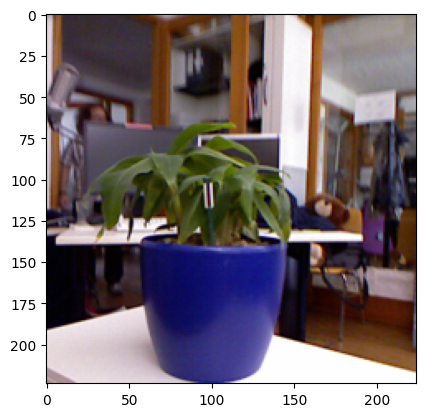

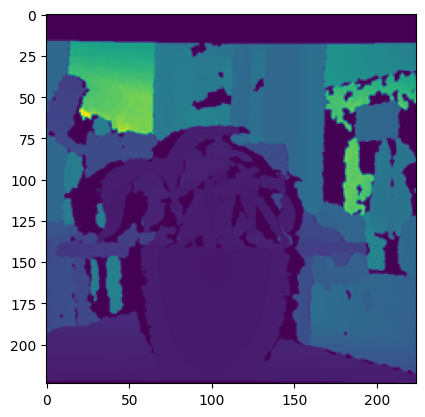

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/home/zqy/hzt/TAC/data/rgbd_data/tumrgbd_clean_resize/rgbd_dataset_freiburg1_plant/rgb/264.png")
depth = Image.open("/home/zqy/hzt/TAC/data/rgbd_data/tumrgbd_clean_resize/rgbd_dataset_freiburg1_plant/depth/264.png")
rgb = np.array(rgb)
depth = np.array(depth).astype(float)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth)
print(depth.min(), depth.max())

## SceneNet

Link: https://robotvault.bitbucket.io/scenenet-rgbd.html

In [ ]:
# check if scenenet and tum have the same scale value
from PIL import Image
import numpy as np
img1 = Image.open("/home/zqy/hzt/TAC/data/rgbd_data/scenenet/train/4/4007/depth/450.png")
img2 = Image.open("/home/zqy/hzt/TAC/data/rgbd_data/tumrgbd_clean/rgbd_dataset_freiburg1_desk_secret/depth/200.png")
img1_arr = np.array(img1)
img2_arr = np.array(img2)
print(img1_arr.max(), img2_arr.max())

In [ ]:
# find the max depth, 20m
import os
num = 0
max_depth=0
for root, dirs, files in os.walk("/home/zqy/hzt/TAC/data/rgbd_data/scenenet/train"):
    if "depth" in root:
        for f in files:
            filename = os.path.join(root,f)
            img = Image.open(filename)
            max_depth = max(max_depth, np.array(img).max())

In [ ]:
import matplotlib.pyplot as plt
a = np.array(img)
plt.imshow(a/1000)

In [ ]:
os.system('find . -type d -name photo | rename "s/photo/rgb/"')

resize and center crop

In [13]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
def crop_to_square(img):
    width, height = img.size   # Get dimensions
    if width==height:
        return img
    if width>height:
        new_width = height
        new_height = height
    else:
        new_width = width
        new_height = width

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    return img
def resize_square(img, size):
    width, height = img.size   # Get dimensions
    assert width==height
    if width==size:
        return img
    img = img.resize((size,size), resample=Image.BICUBIC)
    return img
for i in [0]:
    FOLDER = "/home/zqy/hzt/TAC/data/rgbd_data/scenenet_resize/val/%d"%(i)
    all_paths = []
    for root, dirs, files in os.walk(FOLDER):
        if files:
            for fname in files:
                if ".png" in fname or ".jpg" in fname:
                    path = os.path.join(root, fname)
                    all_paths.append(path)
    for path in tqdm(all_paths):
        img = Image.open(path)
        img = crop_to_square(img)
        img = resize_square(img, 224)
        img.save(path)



  0%|          | 0/600000 [00:00<?, ?it/s]

602.0 5245.0


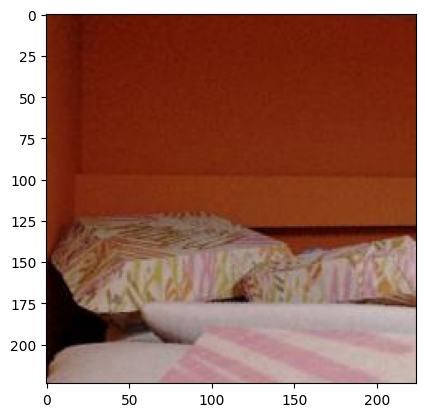

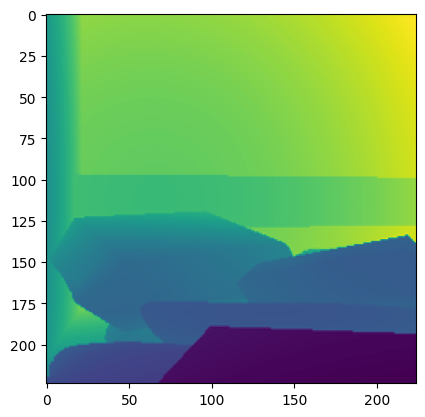

In [14]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/home/zqy/hzt/TAC/data/rgbd_data/scenenet_resize/val/0/0/rgb/50.jpg")
depth = Image.open("/home/zqy/hzt/TAC/data/rgbd_data/scenenet_resize/val/0/0/depth/50.png")
rgb = np.array(rgb)
depth = np.array(depth).astype(float)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth)
print(depth.min(), depth.max())

## NYUv2
save to image
depth scale 1000

Link: https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html

In [ ]:
import h5py
import os
from tqdm.notebook import tqdm
os.system("rm -r /home/zqy/hzt/TAC/data/rgbd_data/nyuv2/train /home/zqy/hzt/TAC/data/rgbd_data/nyuv2/val")
os.makedirs("/home/zqy/hzt/TAC/data/rgbd_data/nyuv2/train")
os.makedirs("/home/zqy/hzt/TAC/data/rgbd_data/nyuv2/val")

folder_temp = "/home/zqy/hzt/TAC/data/rgbd_data/nyuv2/{}/{}/{}"
name_temp = "/home/zqy/hzt/TAC/data/rgbd_data/nyuv2/{}/{}/{}/{}.png"
train_num = 1300
# max depth, 10m
max_depth=0
with h5py.File('/home/zqy/hzt/TAC/data/rgbd_data/nyuv2/nyu_depth_v2_labeled.mat','r') as f:
    rgb = f['images']
    depth = f['depths']
    N = rgb.shape[0]
    for i in tqdm(range(train_num)):
        rgbi = rgb[i].transpose(2,1,0)
        rgbi = Image.fromarray(rgbi)
        os.makedirs(folder_temp.format("train",i,"rgb"),exist_ok=True)
        rgbi.save(name_temp.format("train",i,"rgb",i))

        depthi = depth[i].transpose(1,0)
        max_depth = max(max_depth, depthi.max())
        depthi = (depthi*1000).astype(np.int16)
        depthi = Image.fromarray(depthi)
        os.makedirs(folder_temp.format("train",i,"depth"),exist_ok=True)
        depthi.save(name_temp.format("train",i,"depth",i))
    for i in tqdm(range(train_num,N)):
        rgbi = rgb[i].transpose(2,1,0)
        rgbi = Image.fromarray(rgbi)
        os.makedirs(folder_temp.format("val",i,"rgb"),exist_ok=True)
        rgbi.save(name_temp.format("val",i,"rgb",i))
        
        depthi = depth[i].transpose(1,0)
        max_depth = max(max_depth, depthi.max())
        depthi = (depthi*1000).astype(np.int16)
        depthi = Image.fromarray(depthi)
        os.makedirs(folder_temp.format("val",i,"depth"),exist_ok=True)
        depthi.save(name_temp.format("val",i,"depth",i))

resize and center crop

In [39]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
def crop_to_square(img):
    width, height = img.size   # Get dimensions
    if width==height:
        return img
    if width>height:
        new_width = height
        new_height = height
    else:
        new_width = width
        new_height = width

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    return img
def resize_square(img, size):
    width, height = img.size   # Get dimensions
    assert width==height
    img = img.resize((size,size), resample=Image.BICUBIC)
    return img
FOLDER = "/home/zqy/hzt/TAC/data/rgbd_data/nyuv2_resize"
all_paths = []
for root, dirs, files in os.walk(FOLDER):
    if files:
        for fname in files:
            if ".png" in fname or ".jpg" in fname:
                path = os.path.join(root, fname)
                all_paths.append(path)
for path in tqdm(all_paths):
    img = Image.open(path)
    img = crop_to_square(img)
    img = resize_square(img, 224)
    img.save(path)



  0%|          | 0/5796 [00:00<?, ?it/s]

1152.0 2607.0


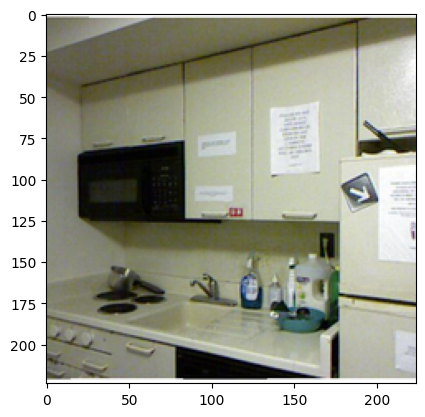

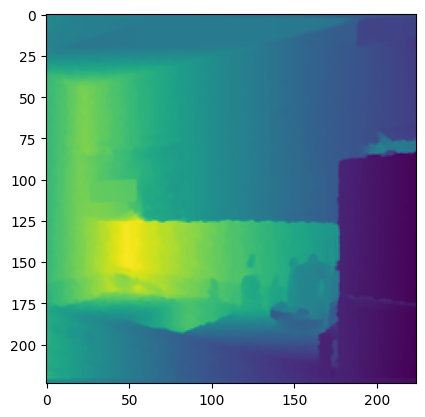

In [15]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/home/zqy/hzt/TAC/data/rgbd_data/nyuv2_resize/train/1/rgb/1.png")
depth = Image.open("/home/zqy/hzt/TAC/data/rgbd_data/nyuv2_resize/train/1/depth/1.png")
rgb = np.array(rgb)
depth = np.array(depth).astype(float)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth)
print(depth.min(), depth.max())

## DIODE
re-construct the file structure

raw data is meters, convert to mm, depth scale 1000

Link: https://diode-dataset.org/

In [ ]:
import os
from PIL import Image
import numpy as np
def work_diode(split, environ):
    all_rgbs = []
    all_depths = []
    all_masks = []
    for root, dirs, files in os.walk("/data/ssd0/hzt/data/rgbd_data/diode/{}/{}".format(split, environ)):
        for file in files:
            if ".png" in file:
                all_rgbs.append(os.path.join(root, file))
            if "depth.npy" in file:
                all_depths.append(os.path.join(root, file))
            if "depth_mask.npy" in file:
                all_masks.append(os.path.join(root, file))
    all_rgbs = sorted(all_rgbs)
    all_depths = sorted(all_depths)
    all_masks = sorted(all_masks)
    folder_temp = "/data/ssd0/hzt/data/rgbd_data/diode_clean/{split}/{environ}/{episode}/{modal}"
    name_temp = "/data/ssd0/hzt/data/rgbd_data/diode_clean/{split}/{environ}/{episode}/{modal}/{index}.png"
    a = 0
    b = 0
    for rgb_name in all_rgbs:
        rgb = Image.open(rgb_name)
        depth_name = rgb_name.replace(".png","_depth.npy")
        mask_name = rgb_name.replace(".png","_depth_mask.npy")
        depth = (np.load(depth_name)*1000.0).astype(np.int32)
        mask = np.load(mask_name)
        depth[(mask==0)] = 0
        depth = Image.fromarray(np.squeeze(depth))

        info = os.path.basename(rgb_name).replace(".png","").split("_")
        episode = int(int(info[1])*10+int(info[-1])/10)
        a = max(a, int(info[-1])/10)
        if int(info[1])>b:
            b = int(info[1])
            print("Current scan ", b)
        assert int(info[-2])%10==0
        assert int(info[-1])%10==0
        assert a<10
        index = int(info[-2])

        os.makedirs(folder_temp.format(split=split, environ=environ, episode=episode, modal="rgb"),exist_ok=True)
        os.makedirs(folder_temp.format(split=split, environ=environ, episode=episode, modal="depth"),exist_ok=True)
        rgb.save(name_temp.format(split=split, environ=environ, episode=episode, modal="rgb", index=index))
        depth.save(name_temp.format(split=split, environ=environ, episode=episode, modal="depth", index=index))
    print(a)

In [ ]:
# os.system("rm -r /data/ssd0/hzt/data/rgbd_data/diode_clean")
for split in ["train","val"]:
    for environ in ["indoors","outdoor"]:
        work_diode(split, environ)

resize and center crop

In [49]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
def crop_to_square(img):
    width, height = img.size   # Get dimensions
    if width==height:
        return img
    if width>height:
        new_width = height
        new_height = height
    else:
        new_width = width
        new_height = width

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    return img
def resize_square(img, size):
    width, height = img.size   # Get dimensions
    assert width==height
    img = img.resize((size,size), resample=Image.BICUBIC)
    return img
FOLDER = "/home/zqy/hzt/TAC/data/rgbd_data/diode_clean_resize"
all_paths = []
for root, dirs, files in os.walk(FOLDER):
    if files:
        for fname in files:
            if ".png" in fname or ".jpg" in fname:
                path = os.path.join(root, fname)
                all_paths.append(path)
for path in tqdm(all_paths):
    img = Image.open(path)
    img = crop_to_square(img)
    img = resize_square(img, 224)
    img.save(path)

  0%|          | 0/111348 [00:00<?, ?it/s]

0.0 6259.0


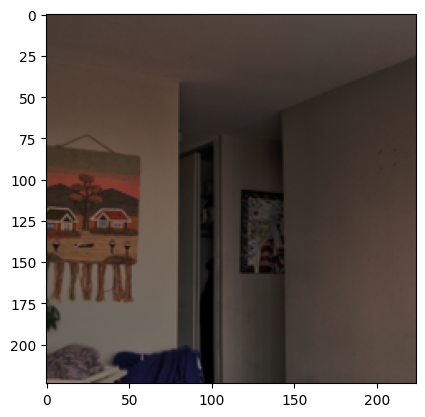

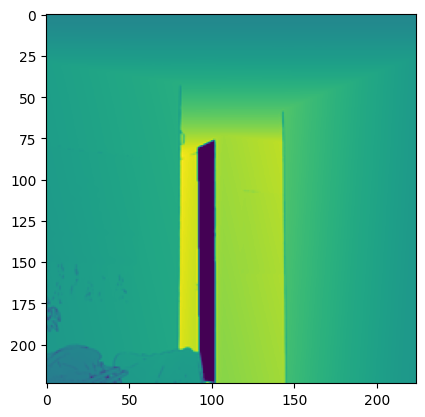

In [29]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/home/zqy/hzt/TAC/data/rgbd_data/diode_clean_resize/val/indoors/1842/rgb/140.png")
depth = Image.open("/home/zqy/hzt/TAC/data/rgbd_data/diode_clean_resize/val/indoors/1842/depth/140.png")
rgb = np.array(rgb)
depth = np.array(depth).astype(float)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth)
print(depth.min(), depth.max())

## HM3D

Requires access from https://aihabitat.org/datasets/hm3d/

After downloading all scenes and installing Habitat-lab, run `python ./hm3d_data/hm3d_data_mp.py --world_size 4 --total_episodes 512000 --split train` to generate train data.

776.0 7344.0


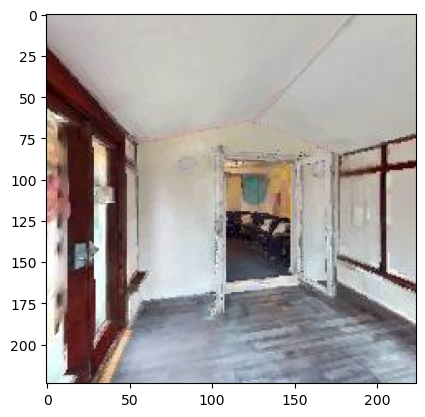

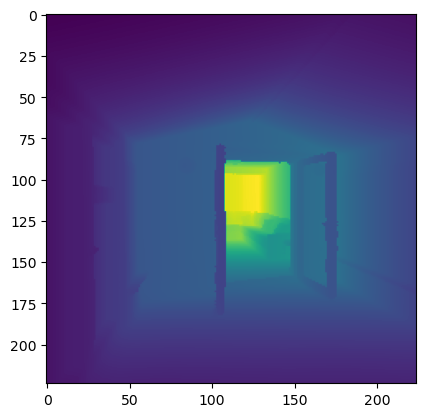

In [7]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/root/TAC/data/hm3d_rgbd/train/14/140002/rgb/70.jpg")
depth = Image.open("/root/TAC/data/hm3d_rgbd/train/14/140002/depth/70.png")
rgb = np.array(rgb)
depth = np.array(depth).astype(float)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth)
print(depth.min(), depth.max())

## SUN 3D

Link: https://sun3d.cs.princeton.edu/

Download instructions:

```
lftp -c "mirror --exclude APCdata/ --exclude SUNRGBD/ --exclude SUNRGBDv2 --exclude SUNRGBDv2Test/ --exclude align_kv2/ --exclude demo/ --exclude kinect2data/ --exclude rawdata_beforecrop/ --parallel=100 https://sun3d.cs.princeton.edu/data/; exit"
```

Notes for raw depth format:

+ We assume the depths and the images are pre-algined.
+ We save the depth as interger in millimeter = 0.001 meter.
+ We use 16-bit PNG file to save the depth.
+ We circularly shift 3 bit in the PNG file so that the depth image look nice in a typical image viewer. (otherwise, it will be too dark to see anything)
+ Therefore, in the code, during data loading, we have to shift the 3 bit back.

In [64]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
FOLDER = "/home/zqy/hzt/TAC/data/rgbd_data/sunrgbd/"
rgbs = []
depths = []
for root, dirs, files in os.walk(FOLDER):
    if "depth_bfx" in root:
        path = os.path.join(root, files[0])
        depths.append(path)
        rgb_dir = os.path.dirname(path).replace("depth_bfx","image")
        rgbs.append(os.path.join(rgb_dir, list(os.listdir(rgb_dir))[0]))
split_point = 7000
TRAIN_FOLDER = "/home/zqy/hzt/TAC/data/rgbd_data/sunrgbd/train"
VAL_FOLDER = "/home/zqy/hzt/TAC/data/rgbd_data/sunrgbd/val"
os.makedirs(TRAIN_FOLDER, exist_ok=True)
os.makedirs(VAL_FOLDER, exist_ok=True)
for i in range(split_point):
    source_rgb = rgbs[i]
    target_rgb = os.path.join(TRAIN_FOLDER, )

In [3]:
## re-organize folders
import copy
import shutil
import glob
import os
import random
from tqdm.notebook import tqdm
FOLDER = "/root/TAC/data/sun3d/data"
source_folders = []
fixed_folders = [os.path.join(FOLDER,v) for v in os.listdir(FOLDER)]
DOWNSAMPLE = 1
for fd in fixed_folders:
    if not os.path.exists(os.path.join(fd,"image")):
        for sub_fd in os.listdir(os.path.join(fd)):
            source_folders.append(os.path.join(fd, sub_fd))
    else:
        source_folders.append(fd)
for i, fd in tqdm(enumerate(source_folders)):
    assert os.path.exists(os.path.join(fd,"image"))
print(len(source_folders))
random.seed(0)
random.shuffle(source_folders)
train_folders = source_folders[0:383]
val_folders = source_folders[383:]

# # calculate val num
TARGET_FOLDER = "/root/TAC/data/sun3d/train"
total = 0
for i, fd in tqdm(enumerate(val_folders)):
    rgbs = list(glob.glob(os.path.join(fd, "image", "*.jpg")))
    total += len(rgbs)
print(total)

# # train
TARGET_FOLDER = "/root/TAC/data/sun3d/train"
for i, fd in tqdm(enumerate(train_folders)):
    rgbs = sorted(glob.glob(os.path.join(fd, "image", "*.jpg")))
    depths = sorted(glob.glob(os.path.join(fd, "depth", "*.png")))
    j = 0
    k = 0
    os.makedirs(os.path.join(TARGET_FOLDER, str(i), "rgb"), exist_ok=True)
    os.makedirs(os.path.join(TARGET_FOLDER, str(i), "depth"), exist_ok=True)
    while j<len(rgbs) and k <len(depths):
        source_rgb = rgbs[j]
        target_rgb = rgbs[j]
        idx_rgb = int(os.path.basename(target_rgb).split("-")[0])
        target_rgb = os.path.join(TARGET_FOLDER, str(i), "rgb", str(idx_rgb)+".jpg")

        source_depth = depths[k]
        target_depth = depths[k]
        idx_depth = int(os.path.basename(target_depth).split("-")[0])
        target_depth = os.path.join(TARGET_FOLDER, str(i), "depth", str(idx_depth)+".png")
        if idx_rgb==idx_depth:
            shutil.move(source_rgb, target_rgb)
            shutil.move(source_depth, target_depth)
            j+=1
            k+=1
        elif idx_rgb<idx_depth:
            j+=1
        else:
            k+=1

# # # val
TARGET_FOLDER = "/root/TAC/data/sun3d/val"
for i, fd in tqdm(enumerate(val_folders)):
    i = i
    rgbs = sorted(glob.glob(os.path.join(fd, "image", "*.jpg")))
    depths = sorted(glob.glob(os.path.join(fd, "depth", "*.png")))
    j = 0
    k = 0
    os.makedirs(os.path.join(TARGET_FOLDER, str(i), "rgb"), exist_ok=True)
    os.makedirs(os.path.join(TARGET_FOLDER, str(i), "depth"), exist_ok=True)
    while j<len(rgbs) and k <len(depths):
        source_rgb = rgbs[j]
        target_rgb = rgbs[j]
        idx_rgb = int(os.path.basename(target_rgb).split("-")[0])
        target_rgb = os.path.join(TARGET_FOLDER, str(i), "rgb", str(idx_rgb)+".jpg")

        source_depth = depths[k]
        target_depth = depths[k]
        idx_depth = int(os.path.basename(target_depth).split("-")[0])
        target_depth = os.path.join(TARGET_FOLDER, str(i), "depth", str(idx_depth)+".png")
        if idx_rgb==idx_depth:
            shutil.move(source_rgb, target_rgb)
            shutil.move(source_depth, target_depth)
            j+=1
            k+=1
        elif idx_rgb<idx_depth:
            j+=1
        else:
            k+=1
# TARGET_FOLDER = "/root/TAC/data/sun3d/data"
# total=0
# for root, dirs, files in os.walk(TARGET_FOLDER):
#     if files:
#         for fname in files:
#             if ".jpg" in fname:
#                 total+=1
# print(total)


0it [00:00, ?it/s]

413


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0it [00:00, ?it/s]

resize and center crop

In [9]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
def crop_to_square(img):
    width, height = img.size   # Get dimensions
    if width==height:
        return img
    if width>height:
        new_width = height
        new_height = height
    else:
        new_width = width
        new_height = width

    left = (width - new_width)//2
    top = (height - new_height)//2
    right = left+new_width
    bottom = top+new_height
    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    return img
def resize_square(img, size, path):
    width, height = img.size   # Get dimensions
    assert width==height
    if width==size:
        return img
    img = img.resize((size,size), resample=Image.BICUBIC)
    img.save(path)
    return img
FOLDER = "/root/TAC/data/sun3d/val"
all_paths = []
for root, dirs, files in os.walk(FOLDER):
    if files:
        for fname in files:
            if ".png" in fname or ".jpg" in fname:
                path = os.path.join(root, fname)
                all_paths.append(path)
for path in tqdm(all_paths):
    img = Image.open(path)
    img = crop_to_square(img)
    img = resize_square(img, 224, path)

  0%|          | 0/341164 [00:00<?, ?it/s]

0.0 39044.0


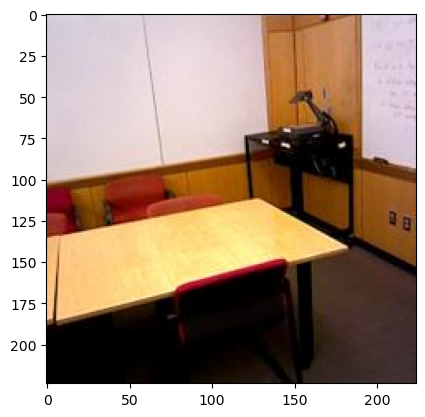

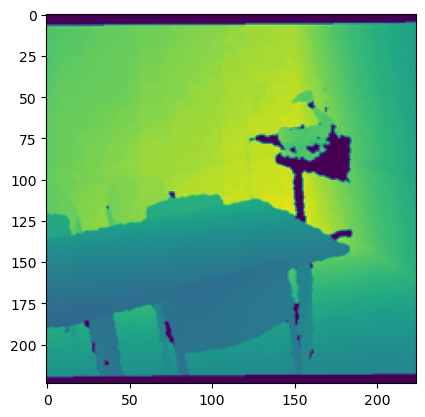

In [6]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/root/TAC/data/rgbd_data/sun3d/train/25/rgb/12.jpg")
depth = Image.open("/root/TAC/data/rgbd_data/sun3d/train/25/depth/12.png")
rgb = np.array(rgb)
depth = np.array(depth).astype(float)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth)
print(depth.min(), depth.max())

In [7]:
TARGET_FOLDER = "/root/TAC/data/sun3d/train"
total=0
for root, dirs, files in os.walk(TARGET_FOLDER):
    if files:
        for fname in files:
            if ".png" in fname:
                total+=1
print(total)

2407496


# Calculate time factor

In [39]:
# https://youtu.be/16s3Pi1InPU
"""
Comparing images using ORB/SIFT feature detectors
and structural similarity index. 
@author: Sreenivas Bhattiprolu
"""


from skimage.metrics import structural_similarity
import skimage
import cv2

import os
import glob
import cv2
import random
import numpy as np
import re
from tqdm.notebook import tqdm
#Works well with images of different dimensions
def orb_sim(img1, img2):
  # SIFT is no longer available in cv2 so using ORB
  orb = cv2.ORB_create()

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
  #perform matches.
  if desc_a is None or desc_b is None:
    return 0
  matches = bf.match(desc_a, desc_b)
  #Look for similar regions with distance < 50. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance < 50]  
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)





**hm3d**

depth scale: 1000

time factor: 87.56

depth scale evidence: `depth_scale = 10 * 1000.0` in hm3d_data/hm3d_data_mp.py

334.0 7281.0


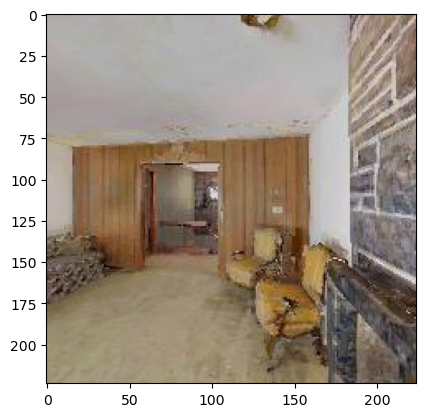

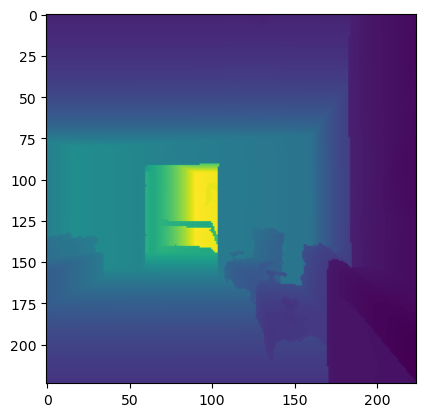

In [1]:
# depth scale
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/root/TAC/data/rgbd_data/hm3d_rgbd/train/25/250011/rgb/170.jpg")
depth = Image.open("/root/TAC/data/rgbd_data/hm3d_rgbd/train/25/250011/depth/170.png")
rgb = np.array(rgb)
depth = np.array(depth).astype(float)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth)
print(depth.min(), depth.max())

time factor

In [61]:
# time scale
def calculate_time_factor(folder, num, limit, threshold):
    all_episodes = list(glob.glob(os.path.join(folder,"*","*")))
    all_episodes = random.sample(all_episodes, num)
    factors = []
    for ep in tqdm(all_episodes):
        rgbs = list(glob.glob(os.path.join(ep,"rgb","*.jpg")))
        rgbs = sorted(rgbs, key=lambda f: int(os.path.basename(f).split(".")[0]))
        times = [int(os.path.basename(v).split(".")[0]) for v in rgbs]
        if len(times)<limit:
            continue
        idx_pool = random.sample(list(range(len(times))), limit)
        for i in idx_pool:
            img1 = cv2.imread(rgbs[i])
            j = i+1
            orb_similarity = 1.0
            while j<len(times):
                img2 = cv2.imread(rgbs[j])
                orb_similarity = orb_sim(img1, img2)
                if orb_similarity<threshold:
                    factors.append(times[j]-times[i])
                    break
                j += 1
    return np.mean(factors)
FOLDER = "/root/TAC/data/rgbd_data/hm3d_rgbd/train"
NUM = 1000
LIMIT = 20
THRESHOLD = 0.2
res = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)
print("Time factor of hm3d is: ", res)

  0%|          | 0/1000 [00:00<?, ?it/s]

87.567834847642


**sun3d**

depth scale: 8000

time factor: 85.91


depth scale evidence:

We save the depth as interger in millimeter = 0.001 meter.
We use 16-bit PNG file to save the depth.
We circularly shift 3 bit in the PNG file so that the depth image look nice in a typical image viewer. (otherwise, it will be too dark to see anything)
Therefore, in the code, during data loading, we have to shift the 3 bit back.

0 21623


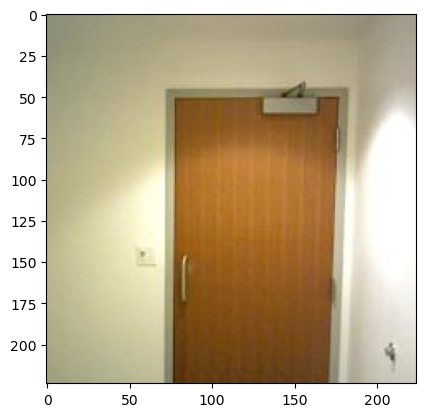

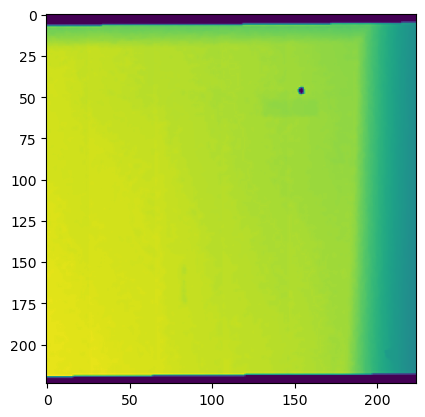

In [36]:
# depth scale
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/root/TAC/data/rgbd_data/sun3d/train/15/rgb/26.jpg")
depth = Image.open("/root/TAC/data/rgbd_data/sun3d/train/15/depth/26.png")
rgb = np.array(rgb)
depth = np.array(depth)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth.astype(float))
print(depth.min(), depth.max())

In [37]:
# a = depth.max()
# def LSHIFTC(n, d, N):  
#     return ((n << d) % (1 << N)) | (n >> (N - d))
# def RSHIFTC(n, d, N):  
#     return ((n << (N-d)) % (1 << N)) | (n >> d)
# print(a, bin(a))
# b = LSHIFTC(a, 3, 16)
# print(b/8, bin(b))
# b = RSHIFTC(a, 3, 16)
# print(b/8, bin(b))
# print(a/8)

21623 0b101010001110111
5239.25 0b1010001110111010
7505.75 0b1110101010001110
2702.875


In [42]:
# time scale
FOLDER = "/root/TAC/data/rgbd_data/sun3d/train"
NUM = 40
LIMIT = 100
THRESHOLD = 0.2
def calculate_time_factor(folder, num, limit, threshold):
    all_episodes = list(glob.glob(os.path.join(folder,"*")))
    all_episodes = random.sample(all_episodes, num)
    factors = []
    for ep in tqdm(all_episodes):
        rgbs = list(glob.glob(os.path.join(ep,"rgb","*.jpg")))
        rgbs = sorted(rgbs, key=lambda f: int(os.path.basename(f).split(".")[0]))
        times = [int(os.path.basename(v).split(".")[0]) for v in rgbs]
        if len(times)<limit:
            continue
        idx_pool = random.sample(list(range(len(times))), limit)
        for i in idx_pool:
            img1 = cv2.imread(rgbs[i])
            j = i+1
            orb_similarity = 1.0
            while j<len(times):
                img2 = cv2.imread(rgbs[j])
                orb_similarity = orb_sim(img1, img2)
                if orb_similarity<threshold:
                    factors.append(times[j]-times[i])
                    break
                j += 1
    return np.mean(factors)
res = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)
print("Time factor of sun3d is: ", res)

  0%|          | 0/40 [00:00<?, ?it/s]

Time factor of sun3d is:  85.91543832428239


**SceneNet**

depth scale: 1000

time factor: 278.17

depth scale evidence: 

depth - which contains the accompanying depth information stored as unsigned 16-bit integers within a PNG. The numbering scheme is the same as for photo (0.png is the first frame). The units are millimeters, a value of 1000 is a meter. Depth is defined as the euclidean ray length from the camera position to the first point of intersection.

1407 6658


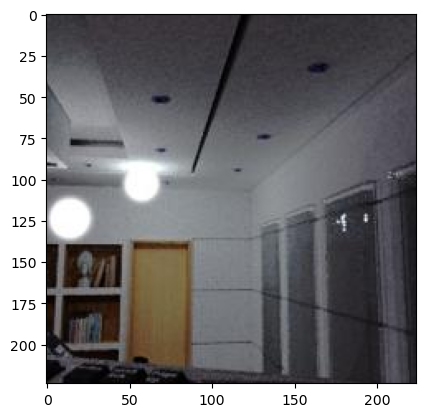

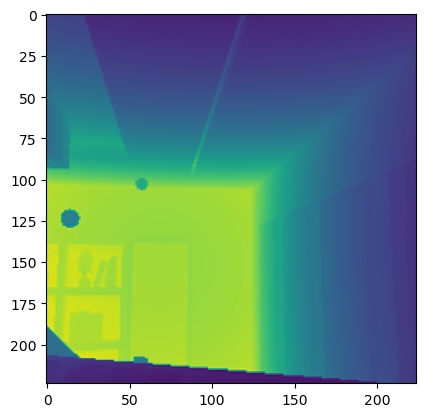

In [43]:
# depth scale
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/root/TAC/data/rgbd_data/scenenet_resize/train/10/10005/rgb/425.jpg")
depth = Image.open("/root/TAC/data/rgbd_data/scenenet_resize/train/10/10005/depth/425.png")
rgb = np.array(rgb)
depth = np.array(depth)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth.astype(float))
print(depth.min(), depth.max())

In [44]:
# time scale
FOLDER = "/root/TAC/data/rgbd_data/scenenet_resize/train"
NUM = 1000
LIMIT = 20
THRESHOLD = 0.2
def calculate_time_factor(folder, num, limit, threshold):
    all_episodes = list(glob.glob(os.path.join(folder,"*","*")))
    all_episodes = random.sample(all_episodes, num)
    factors = []
    for ep in tqdm(all_episodes):
        rgbs = list(glob.glob(os.path.join(ep,"rgb","*.jpg")))
        rgbs = sorted(rgbs, key=lambda f: int(os.path.basename(f).split(".")[0]))
        times = [int(os.path.basename(v).split(".")[0]) for v in rgbs]
        if len(times)<limit:
            continue
        idx_pool = random.sample(list(range(len(times))), limit)
        for i in idx_pool:
            img1 = cv2.imread(rgbs[i])
            j = i+1
            orb_similarity = 1.0
            while j<len(times):
                img2 = cv2.imread(rgbs[j])
                orb_similarity = orb_sim(img1, img2)
                if orb_similarity<threshold:
                    factors.append(times[j]-times[i])
                    break
                j += 1
    return np.mean(factors)
res = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)
print("Time factor of scenenet is: ", res)

  0%|          | 0/1000 [00:00<?, ?it/s]

Time factor of scenenet is:  278.1696730259396


0.3870967741935484


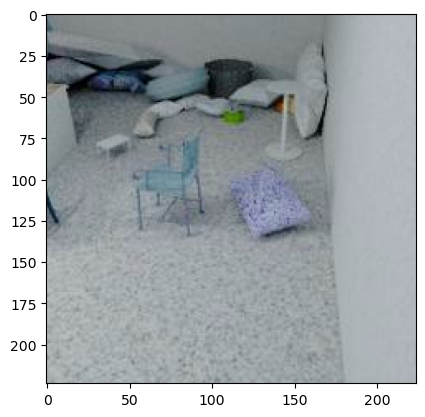

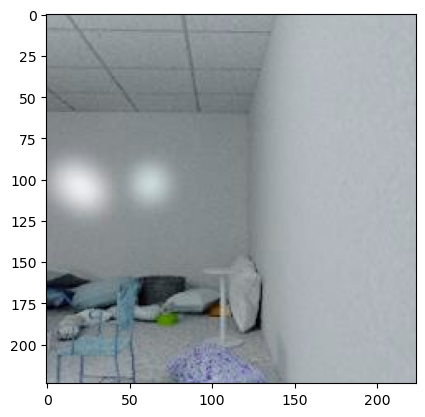

In [63]:
img1 = cv2.imread("/root/TAC/data/rgbd_data/scenenet_resize/train/10/10235/rgb/425.jpg")
img2 = cv2.imread(f"/root/TAC/data/rgbd_data/scenenet_resize/train/10/10235/rgb/{425+275}.jpg")
print(orb_sim(img1, img2))
plt.figure()
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

**diode**

depth scale: 1000

time factor: 36.60

depth scale evidence: 

`depth = (np.load(depth_name)*1000.0).astype(np.int32)`

0 6471


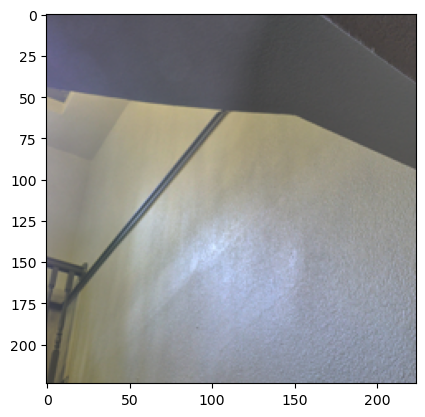

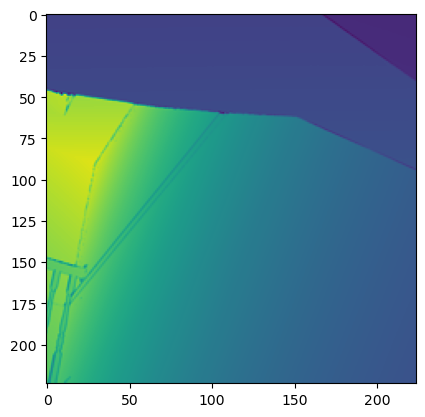

In [70]:
# depth scale
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/root/TAC/data/rgbd_data/diode_clean_resize/train/indoors/75/rgb/140.png")
depth = Image.open("/root/TAC/data/rgbd_data/diode_clean_resize/train/indoors/75/depth/140.png")
rgb = np.array(rgb)
depth = np.array(depth)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth.astype(float))
print(depth.min(), depth.max())

In [84]:
# time scale
FOLDER = "/root/TAC/data/rgbd_data/diode_clean_resize/train"
NUM = 80
LIMIT = 10
THRESHOLD = 0.2
def calculate_time_factor(folder, num, limit, threshold):
    all_episodes = list(glob.glob(os.path.join(folder,"indoors","*")))
    # print(all_episodes)
    all_episodes = random.sample(all_episodes, num)
    factors = []
    for ep in tqdm(all_episodes):
        rgbs = list(glob.glob(os.path.join(ep,"rgb","*.png")))
        rgbs = sorted(rgbs, key=lambda f: int(os.path.basename(f).split(".")[0]))
        times = [int(os.path.basename(v).split(".")[0]) for v in rgbs]
        if len(times)<limit:
            continue
        idx_pool = random.sample(list(range(len(times))), limit)
        for i in idx_pool:
            img1 = cv2.imread(rgbs[i])
            j = i+1
            orb_similarity = 1.0
            while j<len(times):
                img2 = cv2.imread(rgbs[j])
                orb_similarity = orb_sim(img1, img2)
                if orb_similarity<threshold:
                    factors.append(times[j]-times[i])
                    break
                j += 1
    return np.mean(factors)
res = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)
print("Time factor of diode is: ", res)

  0%|          | 0/80 [00:00<?, ?it/s]

Time factor of diode is:  35.509838998211094


**tum**

depth scale: 5000

time factor: 2832.62

depth scale evidence: 

The depth images are scaled by a factor of 5000, i.e., a pixel value of 5000 in the depth image corresponds to a distance of 1 meter from the camera, 10000 to 2 meter distance, etc. A pixel value of 0 means missing value/no data.

0 56156


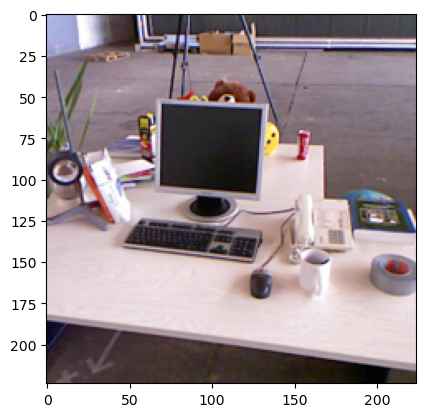

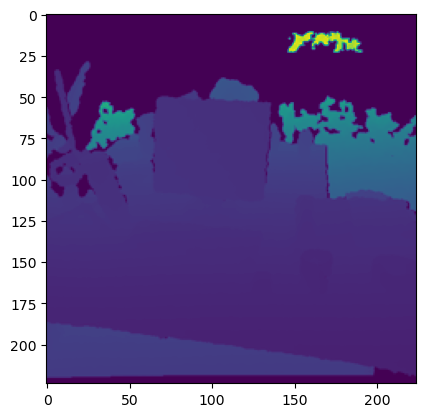

In [86]:
# depth scale
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/root/TAC/data/rgbd_data/tumrgbd_clean_resize/train/rgbd_dataset_freiburg2_desk/rgb/568.png")
depth = Image.open("/root/TAC/data/rgbd_data/tumrgbd_clean_resize/train/rgbd_dataset_freiburg2_desk/depth/568.png")
rgb = np.array(rgb)
depth = np.array(depth)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth.astype(float))
print(depth.min(), depth.max())

In [93]:
# time scale
FOLDER = "/root/TAC/data/rgbd_data/tumrgbd_clean_resize/train"
NUM = 30
LIMIT = 100
THRESHOLD = 0.30
def calculate_time_factor(folder, num, limit, threshold):
    all_episodes = list(glob.glob(os.path.join(folder,"*")))
    # print(all_episodes)
    all_episodes = random.sample(all_episodes, num)
    factors = []
    for ep in tqdm(all_episodes):
        rgbs = list(glob.glob(os.path.join(ep,"rgb","*.png")))
        rgbs = sorted(rgbs, key=lambda f: int(os.path.basename(f).split(".")[0]))
        times = [int(os.path.basename(v).split(".")[0]) for v in rgbs]
        if len(times)<limit:
            continue
        idx_pool = random.sample(list(range(len(times))), limit)
        for i in idx_pool:
            img1 = cv2.imread(rgbs[i])
            j = i+1
            orb_similarity = 1.0
            while j<len(times):
                img2 = cv2.imread(rgbs[j])
                orb_similarity = orb_sim(img1, img2)
                if orb_similarity<threshold:
                    factors.append(times[j]-times[i])
                    break
                j += 1
    return np.mean(factors)
res = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)
print("Time factor of tum is: ", res)

  0%|          | 0/30 [00:00<?, ?it/s]

Time factor of tum is:  2832.6239220097486


0.14285714285714285


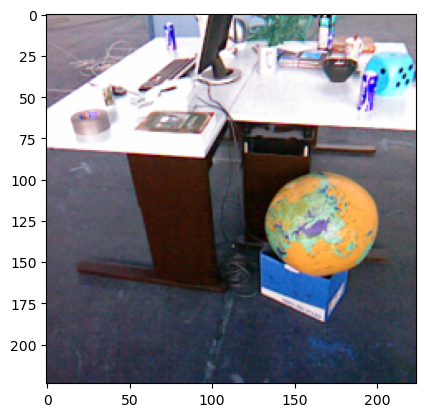

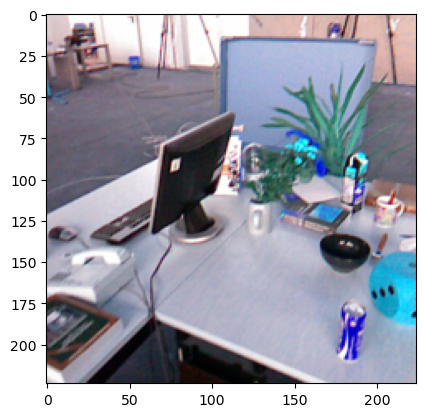

In [91]:
img1 = cv2.imread("/root/TAC/data/rgbd_data/tumrgbd_clean_resize/train/rgbd_dataset_freiburg2_desk/rgb/16237.png")
img2 = cv2.imread(f"/root/TAC/data/rgbd_data/tumrgbd_clean_resize/train/rgbd_dataset_freiburg2_desk/rgb/19707.png")
print(orb_sim(img1, img2))
plt.figure()
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

**NYU**

depth scale: 1000

`depthi = (depthi*1000).astype(np.int16)`

In [ ]:
# depth scale
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
rgb = Image.open("/root/TAC/data/rgbd_data/tumrgbd_clean_resize/train/rgbd_dataset_freiburg2_desk/rgb/568.png")
depth = Image.open("/root/TAC/data/rgbd_data/tumrgbd_clean_resize/train/rgbd_dataset_freiburg2_desk/depth/568.png")
rgb = np.array(rgb)
depth = np.array(depth)
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(depth.astype(float))
print(depth.min(), depth.max())

# Statistics

In [33]:
import glob
import os
import numpy as np
# episode number
FOLDER = "/root/TAC/data/rgbd_data/diode_clean_resize/val"
all_episodes = list(glob.glob(os.path.join(FOLDER,"*","*")))
print("Total episodes", len(all_episodes))
lengths = []
for ep in all_episodes:
    lengths.append(len(glob.glob(os.path.join(ep,"rgb","*"))))
print("Total frames", np.sum(lengths))
print("Avg frames", np.mean(lengths))

Total episodes 109
Total frames 771
Avg frames 7.073394495412844


In [6]:
np.mean(lengths)

64.6355354713314

## Prove the Gaussian

In [2]:
from skimage.metrics import structural_similarity
import skimage
import cv2

import os
import glob
import cv2
import random
import numpy as np
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import make_interp_spline

#Works well with images of different dimensions
def orb_sim(img1, img2):
  # SIFT is no longer available in cv2 so using ORB
  orb = cv2.ORB_create()

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
  #perform matches.
  if desc_a is None or desc_b is None:
    return 0
  matches = bf.match(desc_a, desc_b)
  #Look for similar regions with distance < 50. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance < 50]  
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)

In [13]:
import math
import scipy
from matplotlib import cm

def show_distribution(folder, num, limit):
    num = int(num)
    limit = int(limit)
    if "scenenet" in folder or "hm3d" in folder or "diode" in folder:
        all_episodes = list(glob.glob(os.path.join(folder,"*","*")))
    else:
        all_episodes = list(glob.glob(os.path.join(folder,"*")))
    if "tum" in folder or "diode" in folder:
        posix = "png"
    else:
        posix = "jpg"
    all_episodes = random.sample(all_episodes, num)
    print(len(all_episodes))
    factors = []
    times_all = []
    sims_all = []
    for ep in tqdm(all_episodes):
        rgbs = list(glob.glob(os.path.join(ep,"rgb","*."+posix)))
        rgbs = sorted(rgbs, key=lambda f: int(os.path.basename(f).split(".")[0]))
        times = [int(os.path.basename(v).split(".")[0]) for v in rgbs]
        if len(times)<limit*2+1:
            continue
        idx_center = len(times)//2
        img1 = cv2.imread(rgbs[idx_center])
        sims = []
        for i in range(idx_center-limit, idx_center+limit+1):
            img2 = cv2.imread(rgbs[i])
            sims.append(orb_sim(img1,img2))
        times = np.array(times[idx_center-limit:idx_center+limit+1]).astype(float)
        times = (times-times.mean())/times.std()
        times_all.append(list(times[:limit])+list(times[limit+1:]))
        sims_all.append(sims[:limit]+sims[limit+1:])
        # times_all.append(list(times[:limit])+list(times[limit+1:]))
        # sims_all.append(sims[:limit]+sims[limit+1:])
        # times_all.append(times)
        # sims_all.append(sims)
    times_all = np.array(times_all)
    sims_all = np.array(sims_all)
    sims_mean = sims_all.mean(axis=0)
    times_mean = times_all.mean(axis=0)
    sims_mean = sims_mean/np.max(sims_mean)

    xnew = np.linspace(times_mean.min(), times_mean.max(), 300)
    ynew = make_interp_spline(times_mean, sims_mean)(xnew)
    return xnew, ynew


500


  0%|          | 0/500 [00:00<?, ?it/s]

500


  0%|          | 0/500 [00:00<?, ?it/s]

100


  0%|          | 0/100 [00:00<?, ?it/s]

50


  0%|          | 0/50 [00:00<?, ?it/s]

100


  0%|          | 0/100 [00:00<?, ?it/s]

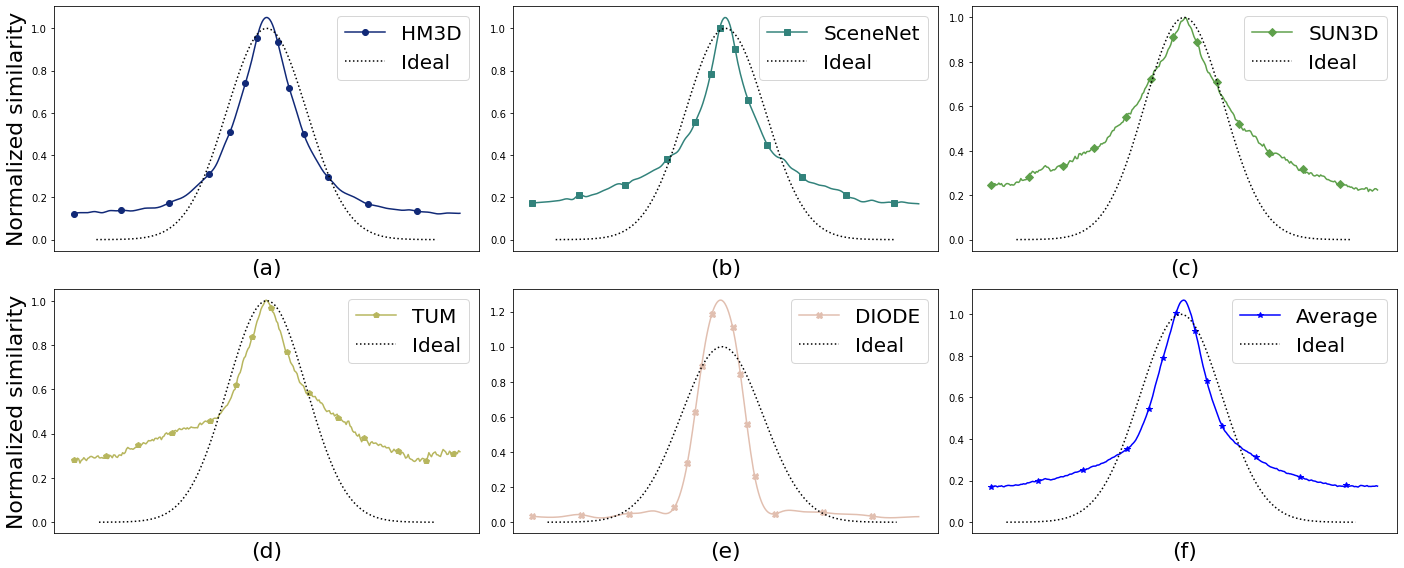

In [21]:
random.seed(25)
np.random.seed(25)
colors = cm.gist_earth([0.1, 0.3, 0.5, 0.7, 0.9])
markers = ["o","s","D","p","X"]
legends = ["HM3D","SceneNet","SUN3D","TUM","DIODE","*Ideal"]
fix, axs = plt.subplots(nrows=2, ncols=3, figsize=(19.6,8))
mu = 0
sigma = 0.25
xref = np.linspace(-1.5, 1.5, 200)
yref = np.exp(-(((xref-mu)/sigma)/2)**2)
yall = []
sz = 20
num = 100
FOLDER = "/root/TAC/data/rgbd_data/hm3d_rgbd/train"
NUM = 5*num
LIMIT = 27
x,y = show_distribution(FOLDER, NUM, LIMIT)
axs[0][0].plot(x,y,color=colors[0], marker=markers[0], markevery=0.1)
axs[0][0].plot(xref,yref,color="black", linestyle=":")
axs[0][0].legend([legends[0], "Ideal"], fontsize=sz)
axs[0][0].set_ylabel("Normalized similarity", fontsize=sz+2)
axs[0][0].set_xlabel("(a)", fontsize=sz+2)
axs[0][0].get_xaxis().set_ticklabels([])
axs[0][0].tick_params(axis='x', length=0)
yall.append(y)

FOLDER = "/root/TAC/data/rgbd_data/scenenet_resize/train"
NUM = 5*num
LIMIT = 33
x,y = show_distribution(FOLDER, NUM, LIMIT)
axs[0][1].plot(x,y,color=colors[1], marker=markers[1], markevery=0.1)
axs[0][1].plot(xref,yref,color="black", linestyle=":")
axs[0][1].legend([legends[1], "Ideal"], fontsize=sz)
# axs[0][1].set_yticks([])
axs[0][1].set_xlabel("(b)", fontsize=sz+2)
axs[0][1].get_xaxis().set_ticklabels([])
axs[0][1].tick_params(axis='x', length=0)
yall.append(y)


FOLDER = "/root/TAC/data/rgbd_data/sun3d/train"
NUM = 1*num
LIMIT = 129
x,y = show_distribution(FOLDER, NUM, LIMIT)
axs[0][2].plot(x,y,color=colors[2], marker=markers[2], markevery=0.1)
axs[0][2].plot(xref,yref,color="black", linestyle=":")
axs[0][2].legend([legends[2], "Ideal"], fontsize=sz)
# axs[0][2].set_yticks([])
axs[0][2].set_xlabel("(c)", fontsize=sz+2)
axs[0][2].get_xaxis().set_ticklabels([])
axs[0][2].tick_params(axis='x', length=0)
yall.append(y)


FOLDER = "/root/TAC/data/rgbd_data/tumrgbd_clean_resize/train"
NUM = 0.5*num
LIMIT = 126
x,y = show_distribution(FOLDER, NUM, LIMIT)
axs[1][0].plot(x,y,color=colors[3], marker=markers[3], markevery=0.1)
axs[1][0].plot(xref,yref,color="black", linestyle=":")
axs[1][0].legend([legends[3], "Ideal"], fontsize=sz)
axs[1][0].set_ylabel("Normalized similarity", fontsize=sz+2)
axs[1][0].set_xlabel("(d)", fontsize=sz+2)
axs[1][0].get_xaxis().set_ticklabels([])
axs[1][0].tick_params(axis='x', length=0)
yall.append(y)


FOLDER = "/root/TAC/data/rgbd_data/diode_clean_resize/train"
NUM = 1*num
LIMIT = 12
x,y = show_distribution(FOLDER, NUM, LIMIT)
axs[1][1].plot(x,y,color=colors[4], marker=markers[4], markevery=0.1)
axs[1][1].plot(xref,yref,color="black", linestyle=":")
axs[1][1].legend([legends[4], "Ideal"], fontsize=sz)
# axs[1][1].set_yticks([])
axs[1][1].set_xlabel("(e)", fontsize=sz+2)
axs[1][1].get_xaxis().set_ticklabels([])
axs[1][1].tick_params(axis='x', length=0)
yall.append(y)

yall = np.array(yall)
yall = np.mean(yall, axis=0)
axs[1][2].plot(x,yall,color="blue", marker="*", markevery=0.1)
axs[1][2].plot(xref,yref,color="black", linestyle=":")
axs[1][2].legend(["Average","Ideal"], fontsize=sz)
# axs[1][2].set_yticks([])
axs[1][2].set_xlabel("(f)", fontsize=sz+2)
axs[1][2].get_xaxis().set_ticklabels([])
axs[1][2].tick_params(axis='x', length=0)
plt.tight_layout()
plt.savefig("gaussian_trend.pdf",bbox_inches="tight")
plt.show()

## Time factor variance

In [65]:
# https://youtu.be/16s3Pi1InPU
"""
Comparing images using ORB/SIFT feature detectors
and structural similarity index. 
@author: Sreenivas Bhattiprolu
"""


from skimage.metrics import structural_similarity
import skimage
import cv2

import os
import glob
import cv2
import random
import numpy as np
import re
from tqdm.notebook import tqdm
#Works well with images of different dimensions
def orb_sim(img1, img2):
  # SIFT is no longer available in cv2 so using ORB
  orb = cv2.ORB_create()

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
  #perform matches.
  if desc_a is None or desc_b is None:
    return 0
  matches = bf.match(desc_a, desc_b)
  #Look for similar regions with distance < 50. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance < 50]  
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)



In [66]:
# time scale
def calculate_time_factor(folder, num, limit, threshold):
    if "scenenet" in folder or "hm3d" in folder or "diode" in folder:
        all_episodes = list(glob.glob(os.path.join(folder,"*","*")))
    else:
        all_episodes = list(glob.glob(os.path.join(folder,"*")))
    if "tum" in folder or "diode" in folder:
        posix = "png"
    else:
        posix = "jpg"
    all_episodes = random.sample(all_episodes, num)
    factors = []
    for ep in tqdm(all_episodes):
        rgbs = list(glob.glob(os.path.join(ep,"rgb","*."+posix)))
        rgbs = sorted(rgbs, key=lambda f: int(os.path.basename(f).split(".")[0]))
        times = [int(os.path.basename(v).split(".")[0]) for v in rgbs]
        if len(times)<limit:
            continue
        idx_pool = random.sample(list(range(len(times))), limit)
        for i in idx_pool:
            img1 = cv2.imread(rgbs[i])
            j = i+1
            orb_similarity = 1.0
            while j<len(times):
                img2 = cv2.imread(rgbs[j])
                orb_similarity = orb_sim(img1, img2)
                if orb_similarity<threshold:
                    factors.append(times[j]-times[i])
                    break
                j += 1
    return factors
FOLDER = "/root/TAC/data/rgbd_data/hm3d_rgbd/train"
NUM = 1000
LIMIT = 20
THRESHOLD = 0.2
res_hm3d = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)

# time scale
FOLDER = "/root/TAC/data/rgbd_data/scenenet_resize/train"
NUM = 1000
LIMIT = 20
THRESHOLD = 0.2
res_scenenet = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)

FOLDER = "/root/TAC/data/rgbd_data/sun3d/train"
NUM = 40
LIMIT = 100
THRESHOLD = 0.2
res_sun3d = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)


# time scale
FOLDER = "/root/TAC/data/rgbd_data/tumrgbd_clean_resize/train"
NUM = 30
LIMIT = 100
THRESHOLD = 0.30
res_tume = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)

# time scale
FOLDER = "/root/TAC/data/rgbd_data/diode_clean_resize/train"
NUM = 80
LIMIT = 10
THRESHOLD = 0.2
res_diode = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [107]:
factors_hm3d = np.log(np.array(res_hm3d))
factors_scenenet = np.log(np.array(res_scenenet))
factors_sun3d = np.log(np.array(res_sun3d))
factors_tum = np.log(np.array(res_tume))
factors_diode = np.log(np.array(res_diode))


In [121]:
factors_hm3d = [v/np.max(res_hm3d) for v in res_hm3d]
factors_scenenet = [v/np.max(res_scenenet) for v in res_scenenet]
factors_sun3d = [v/np.max(res_sun3d) for v in res_sun3d]
factors_tum = [v/np.max(res_tume) for v in res_tume]
factors_diode = [v/np.max(res_diode) for v in res_diode]

/root/miniconda3/lib/python3.8/site-packages/matplotlib/lines.py:1206: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


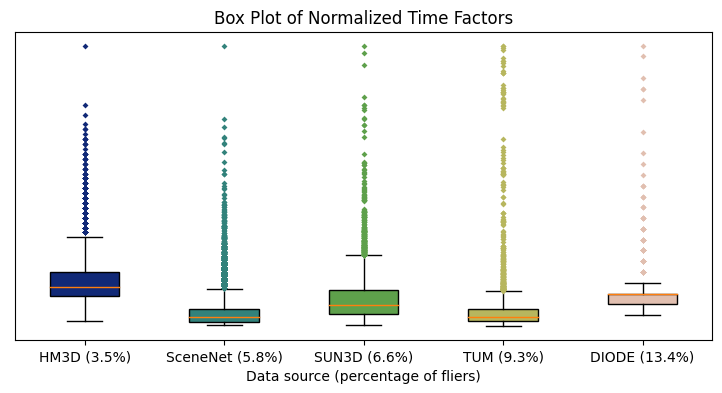

In [156]:

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
green_diamond = green_diamond = dict(markerfacecolor='g', marker='D',markeredgewidth=0.0, markersize=3)
bplot = ax1.boxplot([factors_hm3d, factors_scenenet, factors_sun3d, factors_tum, factors_diode], flierprops=green_diamond,
                     patch_artist=True,  # fill with color
                     labels=["HM3D (3.5%)","SceneNet (5.8%)","SUN3D (6.6%)","TUM (9.3%)","DIODE (13.4%)"])  # will be used to label x-ticks
colors = cm.gist_earth([0.1, 0.3, 0.5, 0.7, 0.9])
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
for patch, color in zip(bplot['fliers'], colors):
    patch.set_markerfacecolor(color)
# plt.gca().set_xticklabels(["HM3D","SceneNet","SUN3D","TUM","DIODE"])
plt.title("Box Plot of Normalized Time Factors")
plt.xlabel("Data source (percentage of fliers)")
plt.yticks([])
plt.savefig("factor_box.pdf",bbox_inches="tight")
plt.show()

In [152]:
tmp = [factors_hm3d,factors_scenenet,factors_sun3d ,factors_tum,factors_diode]
for i in range(5):
    print(len(bplot['fliers'][i].get_xdata())/len(tmp[i]))

0.03464604687406342
0.058560665107820216
0.06630265210608424
0.09276504297994269
0.1339712918660287
